In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization, Activation
from keras.utils import to_categorical
from keras.optimizers import Adam
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
C:\Users\makn0023\Anaconda3\envs\mlc\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\makn0023\Anaconda3\envs\mlc\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\makn0023\Anaconda3\envs\mlc\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\makn0023\Anaconda3\envs\mlc\lib\sit

In [2]:
data = pd.read_csv('icml_face_data.csv')

In [3]:
df = data.copy()

In [4]:
df['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [5]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


C:\Users\makn0023\Anaconda3\envs\mlc\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


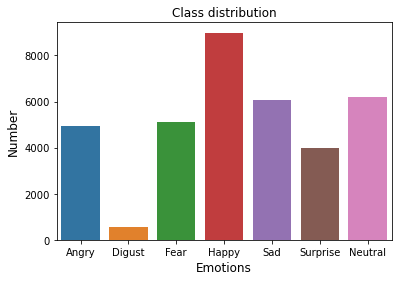

In [6]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

C:\Users\makn0023\Anaconda3\envs\mlc\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
C:\Users\makn0023\Anaconda3\envs\mlc\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
C:\Users\makn0023\Anaconda3\envs\mlc\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

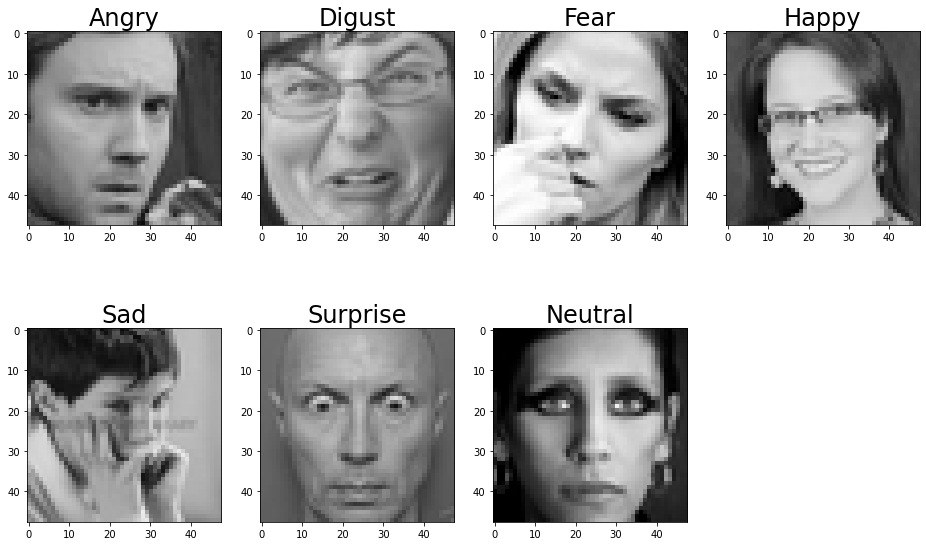

In [28]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1], fontsize=24)

plt.show()  

In [32]:
data_train = data[data["Usage"] == "Training"].copy()
data_val = data[data["Usage"] == "PublicTest"].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print(data_train.shape,
data_val.shape,
data_test.shape)

(28709, 3) (3589, 3) (3589, 3)


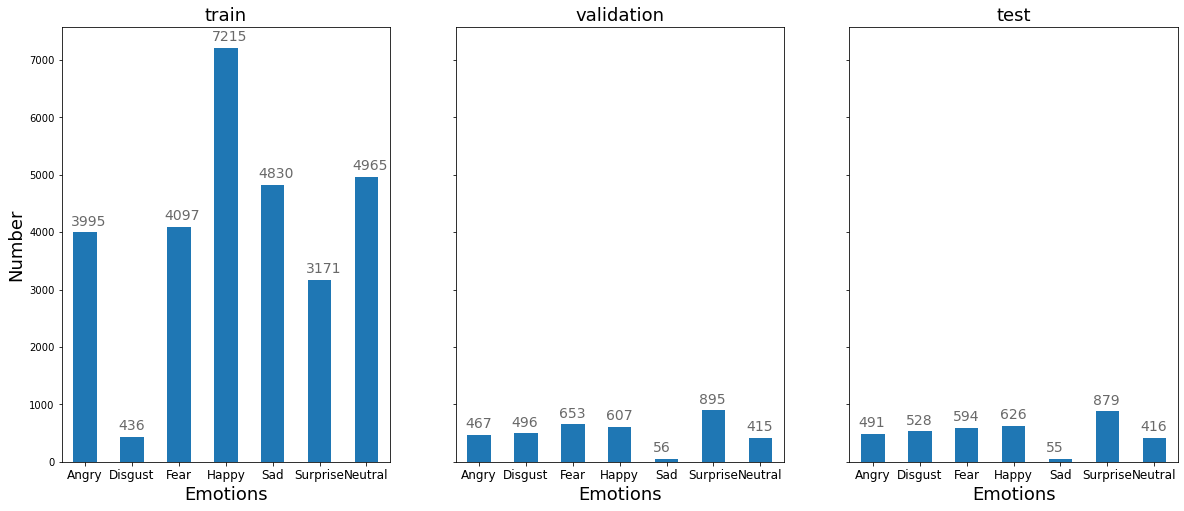

In [37]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels, fontsize=12)
    axe.set_xlabel("Emotions", fontsize=18)
    axe.set_ylabel("Number", fontsize=18)
    axe.set_title(title, fontsize=18)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [62]:
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [63]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [74]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

In [75]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_13 (Batc (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_12 (Activation)   (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_14 (Batc (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_13 (Activation)   (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 256)      

In [80]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

In [82]:
history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50


KeyboardInterrupt: 

## GAN 

In [86]:
df2 = df['pixels'].copy()

In [88]:
df2.to_csv('file.csv')

In [89]:
os.getcwd()

'C:\\Users\\makn0023\\desktop\\ml\\project\\challenges-in-representation-learning-facial-expression-recognition-challenge'

In [103]:
%cd "C:\\Users\\makn0023\\desktop\\ml\\project\\challenges-in-representation-learning-facial-expression-recognition-challenge"

C:\Users\makn0023\desktop\ml\project\challenges-in-representation-learning-facial-expression-recognition-challenge


In [102]:
import numpy as np
import csv
from PIL import Image    

counter = dict()

with open('file.csv',"rt", encoding='UTF-8') as csv_file:
    csv_reader = csv.reader(csv_file)

    # skip headers
    next(csv_reader)

    for row in csv.reader(csv_reader):

        pixels = row[:-1] # without label
        pixels = np.array(pixels, dtype='uint8')
        pixels = pixels.reshape((28, 28))
        image = Image.fromarray(pixels)

        label = row[-1]

        if label not in counter:
            counter[label] = 0
        counter[label] += 1

        filename = '{}{}.jpg'.format(label, counter[label])
        image.save(filename)

        print('saved:', filename)

LookupError: unknown encoding: uint8